Training based on CVE descriptions

In [2]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_descr.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_descr.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_description_ada_embedding'] for item in balanced if item['cwe'] != 'None'])
test = np.array([item['cwe'] for item in balanced if item['cwe'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_description_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train.joblib')

Epoch 1/40
226/226 [==============================] - 0s 2ms/step loss: 1.7758 - acc
Epoch 1 - F1 Score: 0.6219
Saved best model
[0.6218687309053655]
2034/2034 [==============================] - 9s 4ms/step - loss: 1.7724 - accuracy: 0.5305 - val_loss: 1.2262 - val_accuracy: 0.6491
Epoch 2/40
226/226 [==============================] - 0s 1ms/step loss: 1.1271 - accu
Epoch 2 - F1 Score: 0.6864
Saved best model
[0.6218687309053655, 0.6863894394668457]
2034/2034 [==============================] - 6s 3ms/step - loss: 1.1272 - accuracy: 0.6794 - val_loss: 1.0590 - val_accuracy: 0.6993
Epoch 3/40
226/226 [==============================] - 0s 1ms/step loss: 1.0044 - accu
Epoch 3 - F1 Score: 0.7047
Saved best model
[0.6218687309053655, 0.6863894394668457, 0.7047115669146298]
2034/2034 [==============================] - 6s 3ms/step - loss: 1.0042 - accuracy: 0.7143 - val_loss: 0.9951 - val_accuracy: 0.7134
Epoch 4/40
226/226 [==============================] - 0s 1ms/step loss: 0.9330 - accura
E

['label_encoder_train.joblib']

Inference on descriptions

In [1]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
import joblib

# Load the saved model
best_model = joblib.load('CWE_classes.joblib')

# Load the label encoder
label_encoder_train = joblib.load('label_encoder_train.joblib')

# Load the test data
with open('test.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

X_test = np.array([item['cve_description_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert the predicted labels back to their original form
y_pred_original = label_encoder_train.inverse_transform(y_pred)

# Generate and print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))


402/402 [==============================] - 1s 1ms/step
Classification Report:
               precision    recall  f1-score   support

         119     0.9172    0.3935    0.5507      1070
         120     0.3980    0.8020    0.5320       197
         125     0.7358    0.8286    0.7795       531
         134     0.6667    0.8421    0.7442        19
         190     0.6102    0.9091    0.7302       198
          20     0.4632    0.3346    0.3885       810
         200     0.7447    0.5390    0.6254       590
         203     0.4651    0.7407    0.5714        27
          22     0.9069    0.8649    0.8854       518
         269     0.2291    0.6000    0.3316       105
         276     0.2911    0.3594    0.3217        64
         287     0.5418    0.6140    0.5757       285
         295     0.5600    0.6914    0.6188        81
         306     0.3585    0.4043    0.3800        94
         312     0.2586    0.3571    0.3000        42
         319     0.3651    0.4510    0.4035        51
  

Confusion matrix CVE description

['119', '120', '125', '134', '190', '20', '200', '203', '22', '269', '276', '287', '295', '306', '312', '319', '326', '327', '345', '347', '352', '362', '400', '401', '415', '416', '426', '427', '434', '476', '502', '522', '532', '59', '601', '611', '617', '639', '668', '732', '74', '755', '77', '770', '772', '78', '787', '79', '798', '835', '843', '862', '863', '89', '908', '918', '94', 'accuracy']
              precision    recall  f1-score   support

         119     0.9172    0.3935    0.5507      1070
         120     0.3980    0.8020    0.5320       197
         125     0.7358    0.8286    0.7795       531
         134     0.6667    0.8421    0.7442        19
         190     0.6102    0.9091    0.7302       198
          20     0.4632    0.3346    0.3885       810
         200     0.7447    0.5390    0.6254       590
         203     0.4651    0.7407    0.5714        27
          22     0.9069    0.8649    0.8854       518
         269     0.2291    0.6000    0.3316       105
  

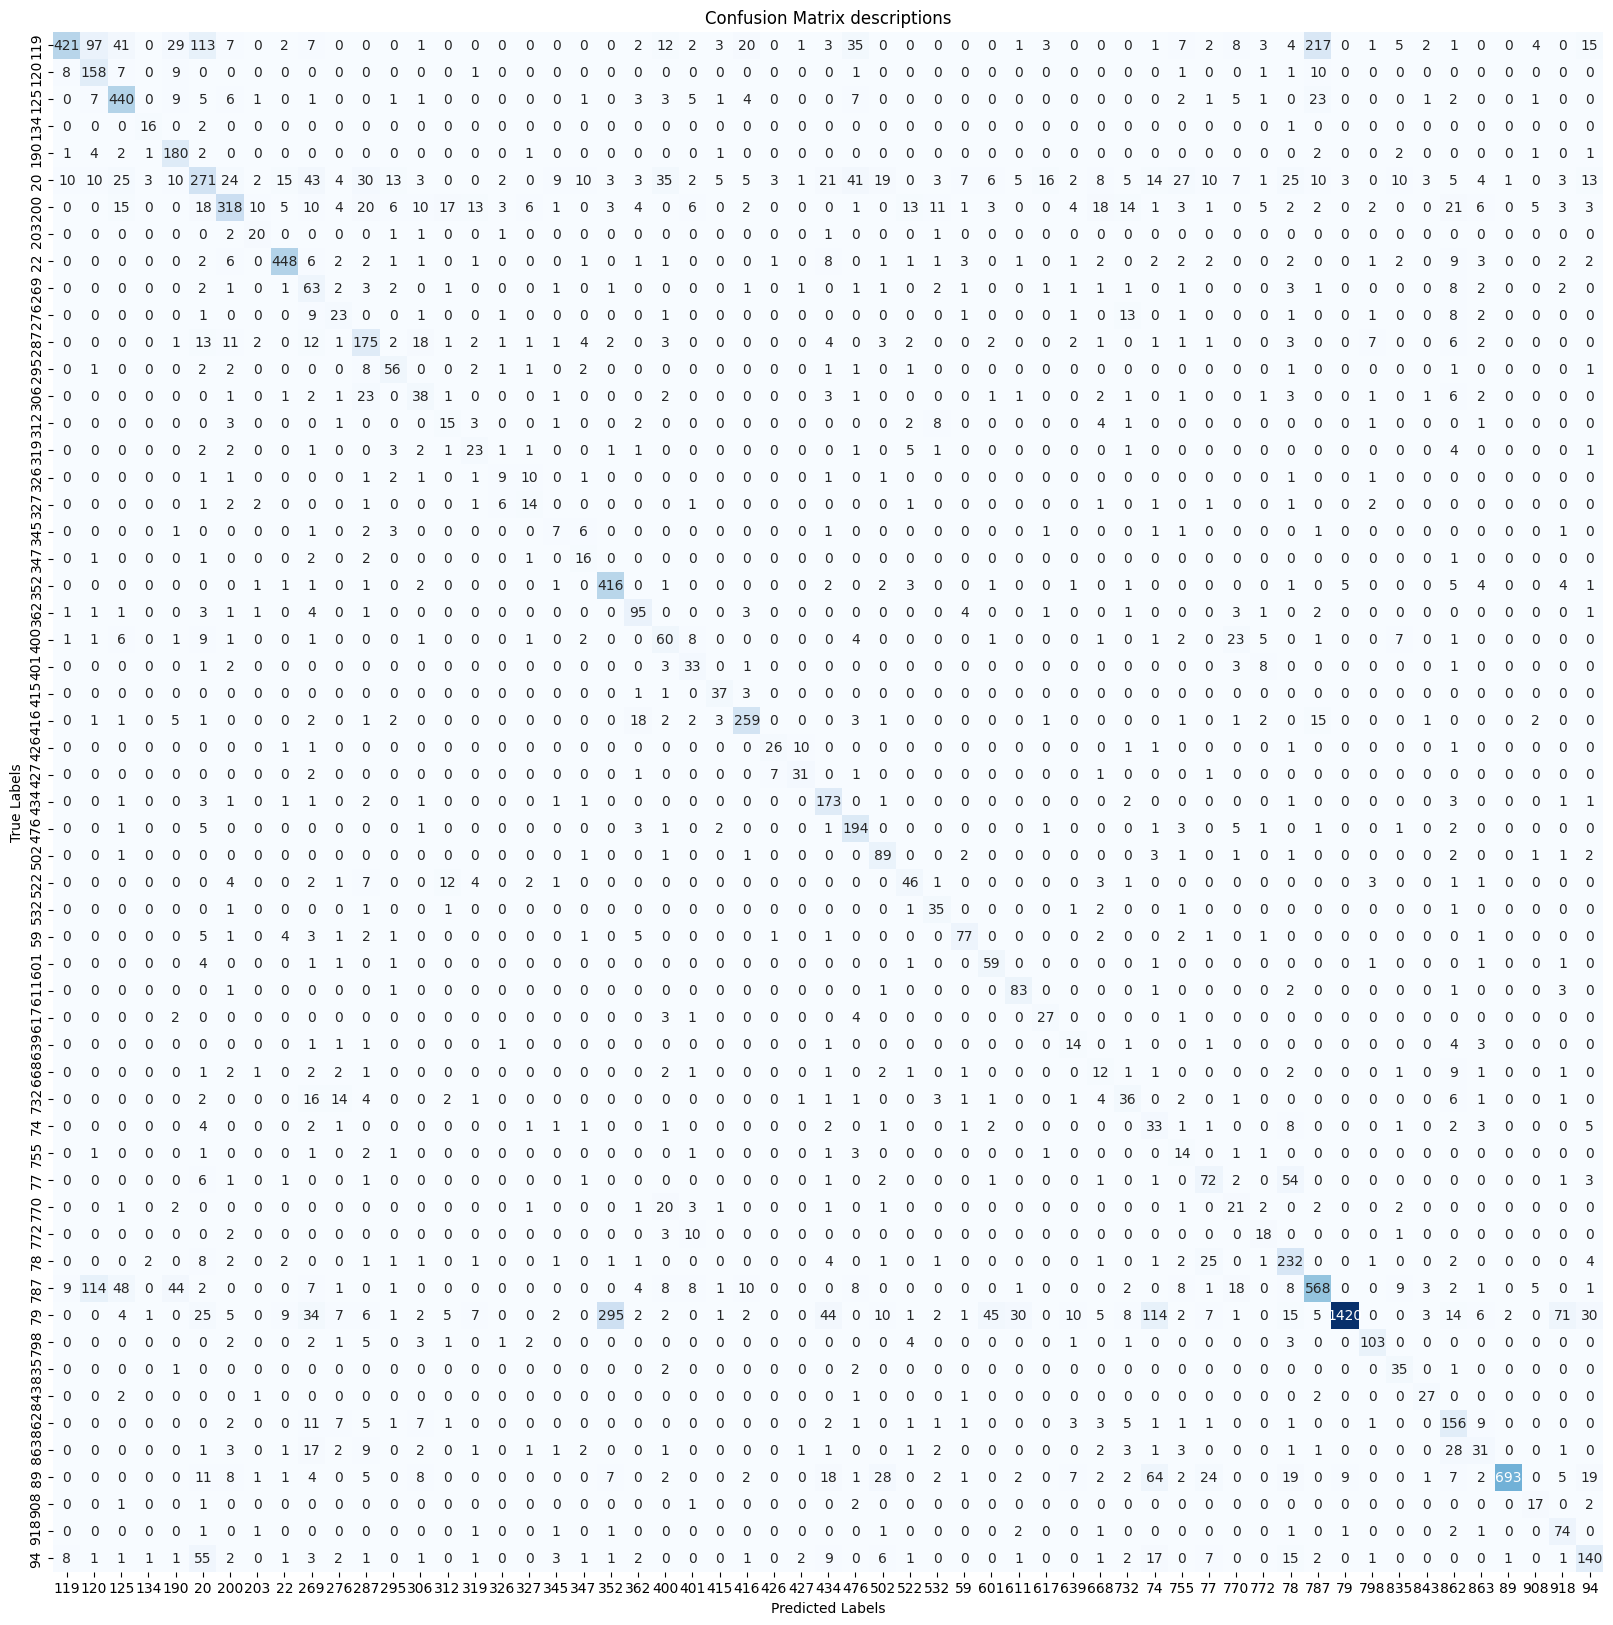

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report

# Assuming you have already generated the classification report
report = classification_report(y_test, y_pred_original, digits=4)

# Split the report by newline character
report_lines = report.split('\n')

# Extract labels from the second line onwards
labels = []
for line in report_lines[2:-3]:
    parts = line.split()
    if len(parts) > 0:
        labels.append(parts[0])

print(labels)
labels.pop(-1)
# Generate classification report
report = classification_report(y_test, y_pred_original, digits=4)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_original)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix descriptions")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Measurements

In [3]:
import joblib# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc1/X_test.joblib')
y_test = joblib.load('reproduc1/y_test.joblib')
y_pred_original = joblib.load('reproduc1/y_pred_original.joblib')
unbalanced = joblib.load('reproduc1/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0
total_words=0
# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    total_words+=description_words
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

print("Average words per sentence:", total_words/i)

Total Sentences Below Short Threshold: 1514
Misclassified Short Sentences: 625
Percentage of Misclassified Short Sentences: 41.28137384412153
Total Sentences Above Long Threshold: 1464
Misclassified Long Sentences: 778
Percentage of Misclassified Long Sentences: 53.14207650273224
Average words per sentence: 40.61624104640299


In [4]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)


Total Sentences: 12845
Misclassified Sentences: 4955
Percentage of Misclassified Sentences: 38.575321136629036


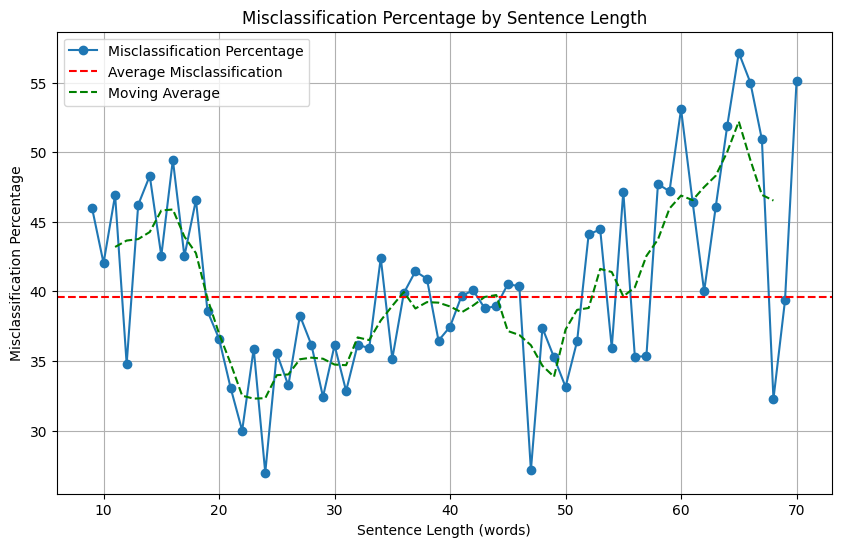

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 70 or description_words < 9:
        # print(unbalanced[i]['cve_description'])
        # print(actual_label, predicted_label)
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()



CVE description training on CWE classes

In [5]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_descr.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_descr.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_description_ada_embedding'] for item in balanced if item['cwe_class'] != 'None'])
test = np.array([item['cwe_class'] for item in balanced if item['cwe_class'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_description_ada_embedding'] for item in unbalanced if item['cwe_class'] != 'None'])
y_test = np.array([item['cwe_class'] for item in unbalanced if item['cwe_class'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_class.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_class.joblib')

Epoch 1/40
226/226 [==============================] - 0s 1ms/step loss: 1.2616 - accur
Epoch 1 - F1 Score: 0.7413
Saved best model
[0.7412779031284252]
2034/2034 [==============================] - 6s 3ms/step - loss: 1.2580 - accuracy: 0.6488 - val_loss: 0.8620 - val_accuracy: 0.7555
Epoch 2/40
226/226 [==============================] - 0s 1ms/step loss: 0.7890 - ac
Epoch 2 - F1 Score: 0.7775
Saved best model
[0.7412779031284252, 0.7774952758282876]
2034/2034 [==============================] - 5s 3ms/step - loss: 0.7884 - accuracy: 0.7726 - val_loss: 0.7572 - val_accuracy: 0.7830
Epoch 3/40
226/226 [==============================] - 0s 1ms/step loss: 0.7007 - ac
Epoch 3 - F1 Score: 0.7874
Saved best model
[0.7412779031284252, 0.7774952758282876, 0.7874408276821855]
2034/2034 [==============================] - 6s 3ms/step - loss: 0.7007 - accuracy: 0.7971 - val_loss: 0.7062 - val_accuracy: 0.7933
Epoch 4/40
226/226 [==============================] - 0s 1ms/step loss: 0.6502 - accu
Epoch

['label_encoder_train_class.joblib']

CVE inference on CWE classes and confusion matrix

['119', '20', '200', '269', '287', '311', '327', '345', '362', '400', '404', '610', '665', '668', '669', '670', '672', '682', '704', '706', '732', '74', '754', '755', '834', '862', '863', '913', 'accuracy']
              precision    recall  f1-score   support

         119     0.9204    0.8554    0.8867      2690
          20     0.5535    0.3000    0.3891       810
         200     0.7638    0.5870    0.6638       661
         269     0.3012    0.4762    0.3690       105
         287     0.6279    0.8038    0.7050       678
         311     0.4275    0.4758    0.4504       124
         327     0.3953    0.4857    0.4359        35
         345     0.6779    0.8770    0.7647       504
         362     0.7280    0.7339    0.7309       124
         400     0.4489    0.7360    0.5577       197
         404     0.7412    0.7326    0.7368        86
         610     0.4787    0.8929    0.6233       252
         665     0.4390    0.7500    0.5538        24
         668     0.5079    0.6400   

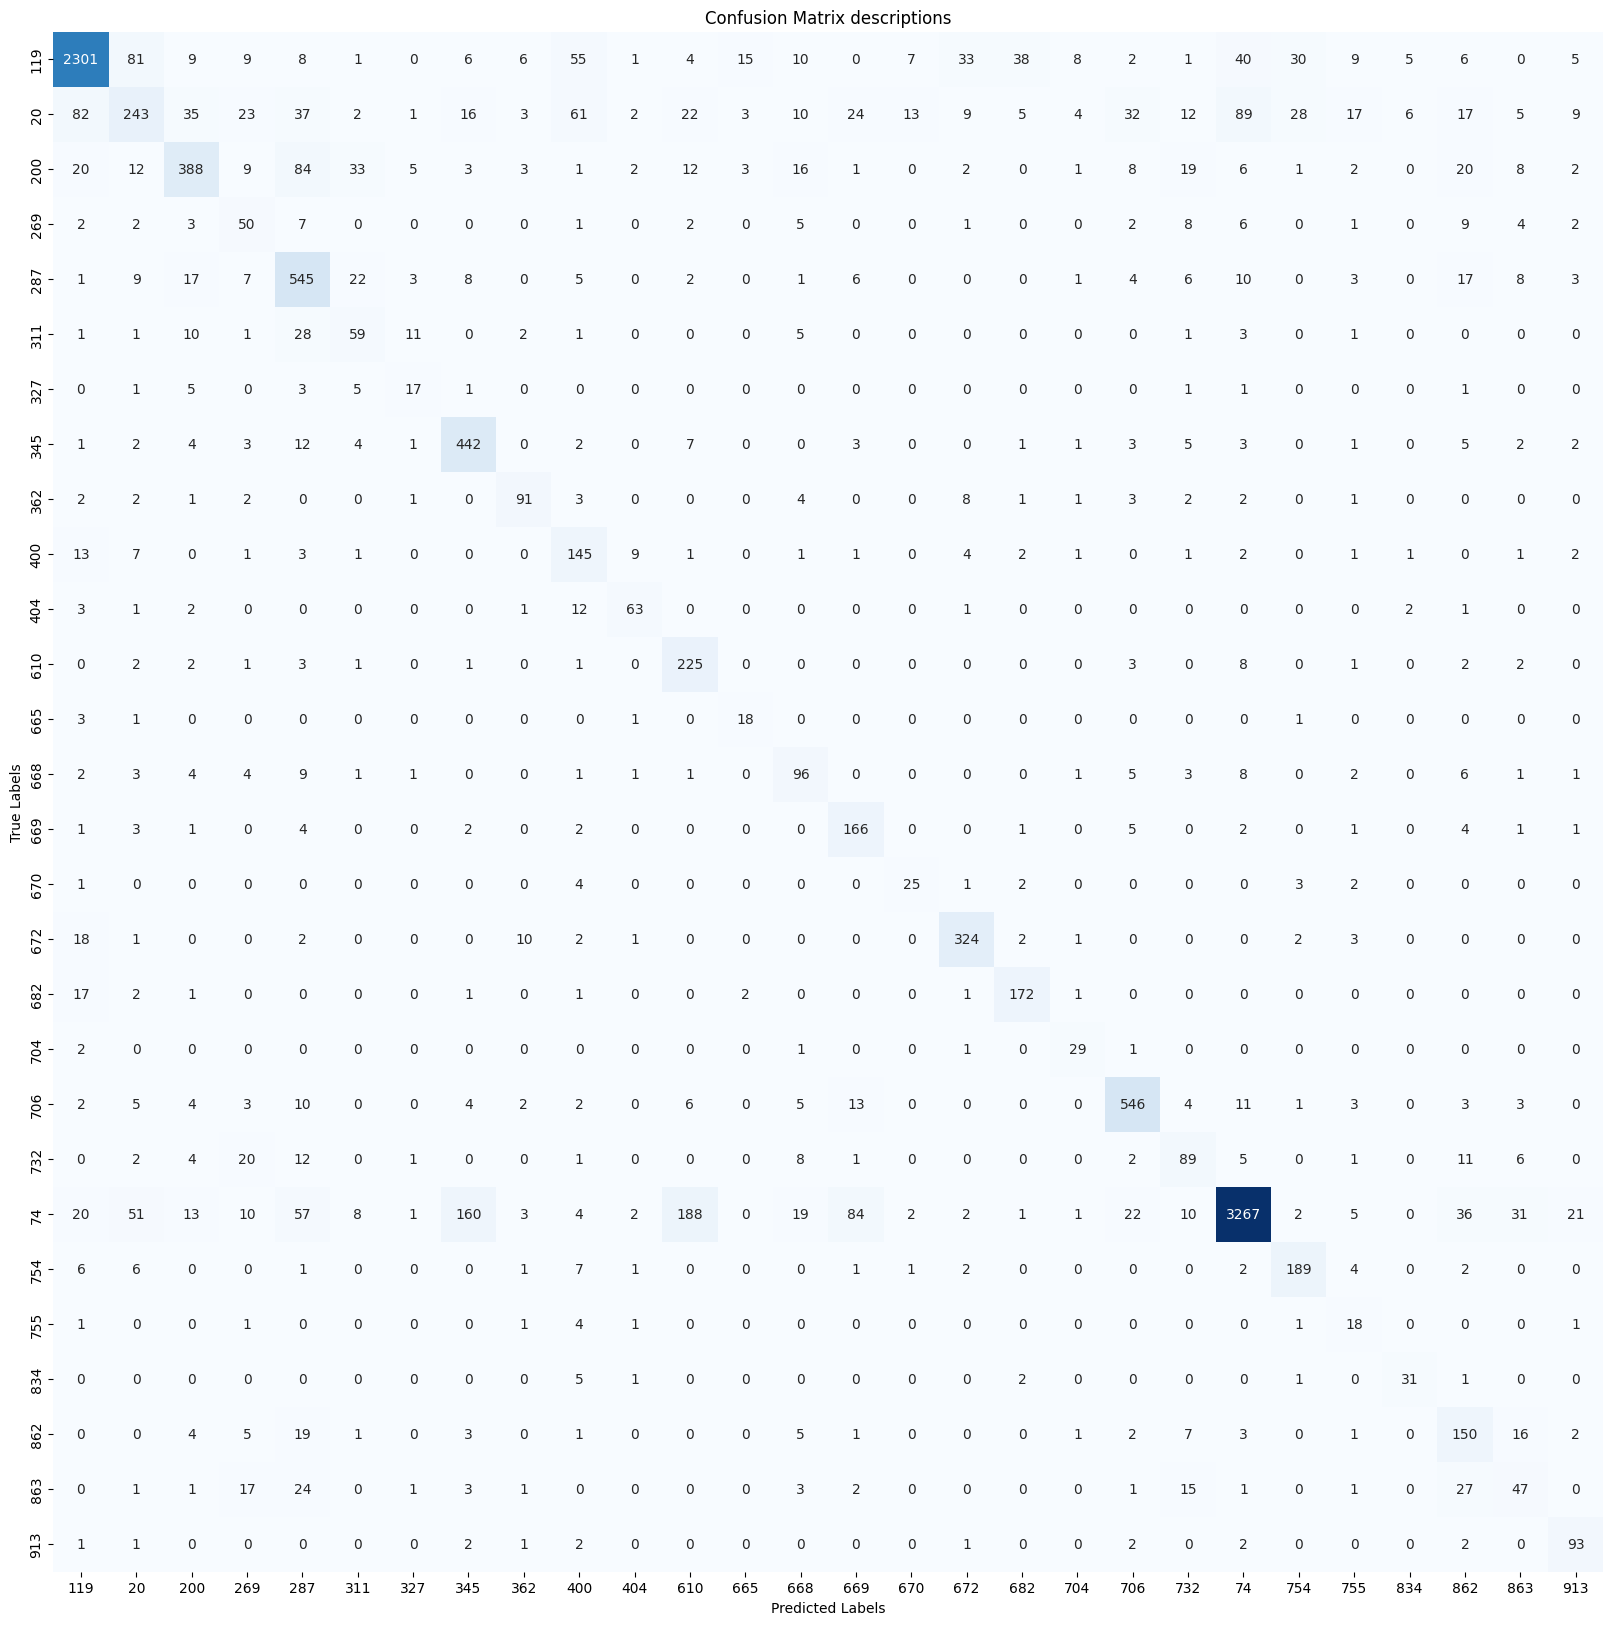

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
report= classification_report(y_test, y_pred_original, digits=4)
report_lines = report.split('\n')

# Extract labels from the second line onwards
labels = []
for line in report_lines[2:-3]:
    parts = line.split()
    if len(parts) > 0:
        labels.append(parts[0])

print(labels)
labels.pop(-1)
# Generate classification report
report = classification_report(y_test, y_pred_original, digits=4)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_original)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix descriptions")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Measurements on CWE classes

In [25]:
# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc2/X_test.joblib')
y_test = joblib.load('reproduc2/y_test.joblib')
y_pred_original = joblib.load('reproduc2/y_pred_original.joblib')
unbalanced = joblib.load('reproduc2/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0
total_words=0
# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    total_words+=description_words
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

print("Average words per sentence:", total_words/i)

Total Sentences Below Short Threshold: 1430
Misclassified Short Sentences: 378
Percentage of Misclassified Short Sentences: 26.433566433566437
Total Sentences Above Long Threshold: 1412
Misclassified Long Sentences: 305
Percentage of Misclassified Long Sentences: 21.600566572237963
Average words per sentence: 40.62028962939894


In [26]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)

Total Sentences: 12845
Misclassified Sentences: 3122
Percentage of Misclassified Sentences: 24.30517711171662


In [24]:
joblib.dump(X_test, 'reproduc2/X_test.joblib')
joblib.dump(y_test, 'reproduc2/y_test.joblib')
joblib.dump(y_pred_original, 'reproduc2/y_pred_original.joblib')
joblib.dump(unbalanced, 'reproduc2/unbalanced.joblib')

['reproduc2/unbalanced.joblib']

In [33]:
short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 60  # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)


Total Sentences Below Short Threshold: 1429
Misclassified Short Sentences: 316
Percentage of Misclassified Short Sentences: 22.113365990202936
Total Sentences Above Long Threshold: 1693
Misclassified Long Sentences: 356
Percentage of Misclassified Long Sentences: 21.027761370348493


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 120:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
# plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4_high_abstr.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_descr_with_embeddings_high_abstr.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_description_ada_embedding'] for item in balanced if item['cwe_high_abstraction'] != 'None'])
test = np.array([item['cwe_high_abstraction'] for item in balanced if item['cwe_high_abstraction'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_description_ada_embedding'] for item in unbalanced if item['cwe_high_abstraction'] != 'None'])
y_test = np.array([item['cwe_high_abstraction'] for item in unbalanced if item['cwe_high_abstraction'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_abs.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_abs.joblib')

Epoch 1/40
225/225 [==============================] - 0s 1ms/step loss: 0.8266 - accur
Epoch 1 - F1 Score: 0.7914
Saved best model
[0.7914138468144832]
2023/2023 [==============================] - 8s 4ms/step - loss: 0.8253 - accuracy: 0.7252 - val_loss: 0.6111 - val_accuracy: 0.7954
Epoch 2/40
225/225 [==============================] - 0s 1ms/step loss: 0.5684 - accu
Epoch 2 - F1 Score: 0.8209
Saved best model
[0.7914138468144832, 0.8208857447579142]
2023/2023 [==============================] - 6s 3ms/step - loss: 0.5686 - accuracy: 0.8152 - val_loss: 0.5452 - val_accuracy: 0.8211
Epoch 3/40
225/225 [==============================] - 0s 1ms/step loss: 0.5231 - accura
Epoch 3 - F1 Score: 0.8210
Saved best model
[0.7914138468144832, 0.8208857447579142, 0.8209627497896016]
2023/2023 [==============================] - 7s 3ms/step - loss: 0.5236 - accuracy: 0.8307 - val_loss: 0.5558 - val_accuracy: 0.8194
Epoch 4/40
225/225 [==============================] - 0s 1ms/step loss: 0.4891 - accu

['label_encoder_train_abs.joblib']

In [29]:
joblib.dump(X_test, 'reproduc3/X_test.joblib')
joblib.dump(y_test, 'reproduc3/y_test.joblib')
joblib.dump(y_pred_original, 'reproduc3/y_pred_original.joblib')
joblib.dump(unbalanced, 'reproduc3/unbalanced.joblib')

['reproduc3/unbalanced.joblib']

In [2]:
import joblib# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc3/X_test.joblib')
y_test = joblib.load('reproduc3/y_test.joblib')
y_pred_original = joblib.load('reproduc3/y_pred_original.joblib')
unbalanced = joblib.load('reproduc3/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0
total_words=0
# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    total_words+=description_words
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

print("Average words per sentence:", total_words/i)


Total Sentences Below Short Threshold: 1429
Misclassified Short Sentences: 310
Percentage of Misclassified Short Sentences: 21.693491952414277
Total Sentences Above Long Threshold: 1405
Misclassified Long Sentences: 310
Percentage of Misclassified Long Sentences: 22.064056939501782
Average words per sentence: 40.6145443196005


In [3]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)

Total Sentences: 12817
Misclassified Sentences: 2858
Percentage of Misclassified Sentences: 22.29850979168292


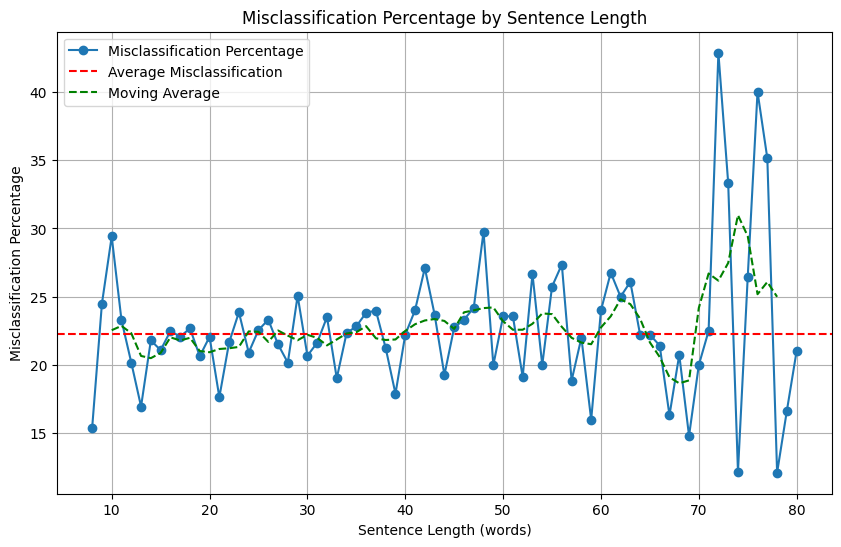

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 80 or description_words < 8:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
for i, (sample, actual_label, predicted_label_descr) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words == 6:
        print(description, actual_label, predicted_label_descr)

Rbot Reaction plugin allows command execution 20 77
DOMPDF before 0.6.2 allows Information Disclosure. 200 200
Veeam ONE Reporter 9.5.0.3201 allows CSRF. 352 352
Severalnines ClusterControl before 1.6.0-4699 allows XSS. 79 79
JD-GUI 1.6.6 allows XSS via util/net/InterProcessCommunicationUtil.java. 79 79
Optergy Proton/Enterprise devices allow Username Disclosure. 862 522
vim is vulnerable to Out-of-bounds Read 125 125
vBulletin 5.4.3 has an Open Redirect. 601 601
Multiple hardcoded credentials in Xsuite 2.x. 798 798
Subrion CMS before 4.1.4 has XSS. 79 79
Collabtive 1.0 has incorrect access control 269 862
plow has local buffer overflow vulnerability 120 120
